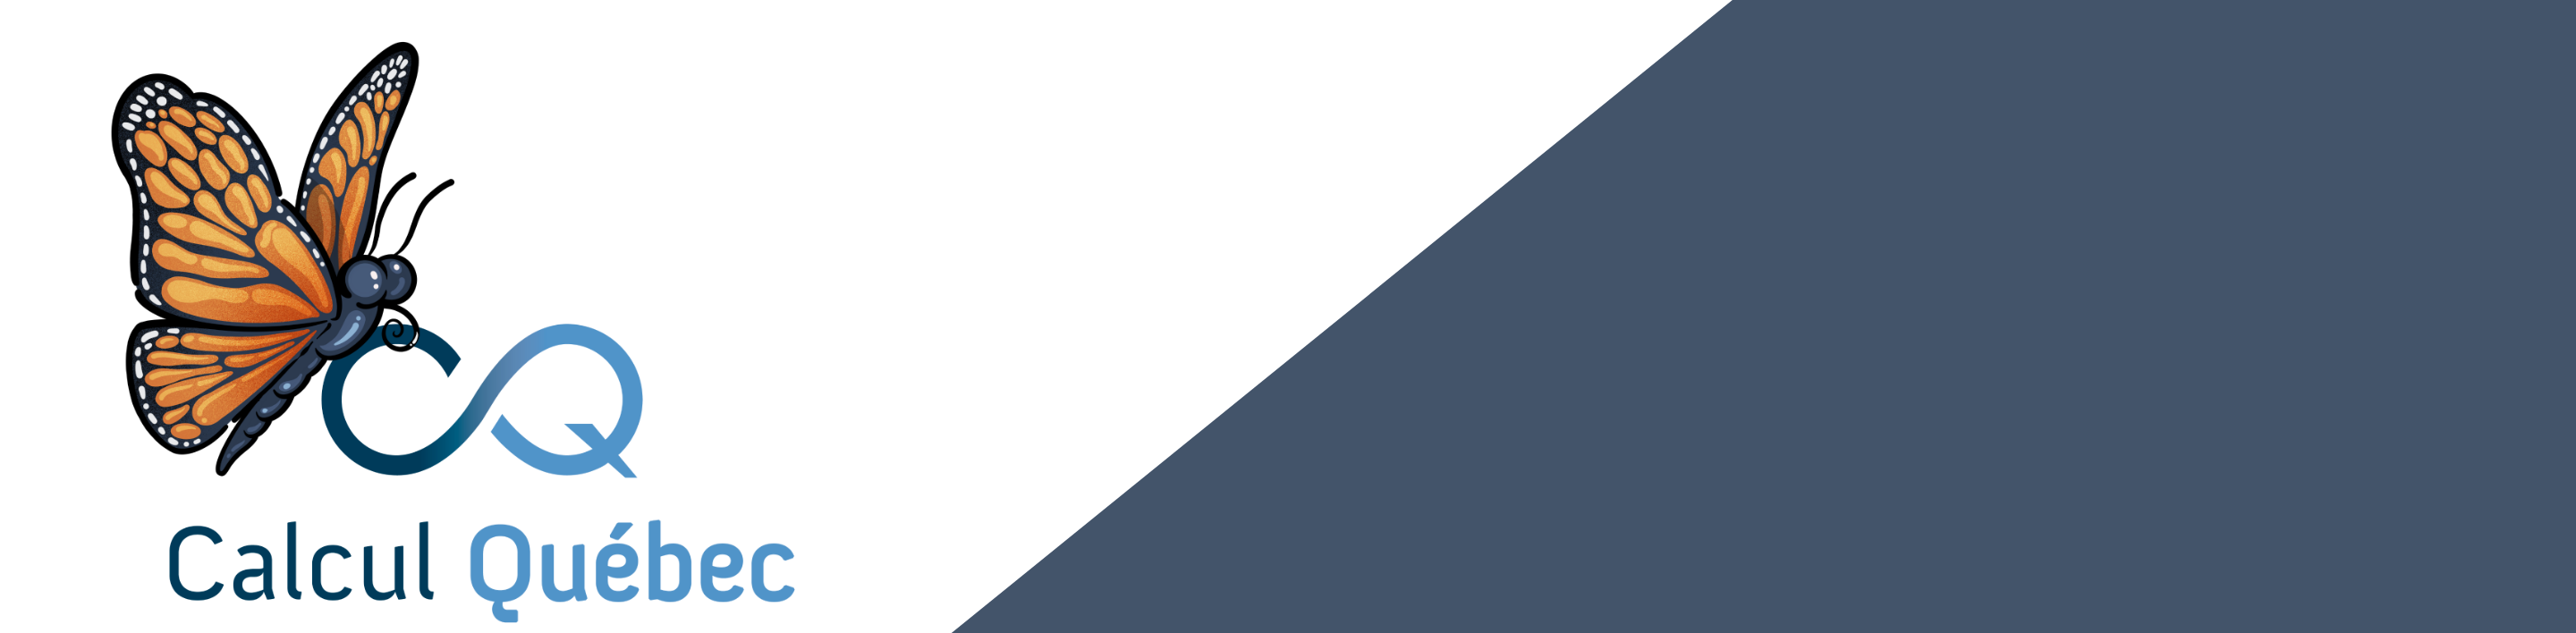

# 0. Introduction 

PennyLane est une plateforme logicielle à code source ouvert pour le calcul quantique différentiable, développée par Xanadu.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from autocorrecteur.correction_2_penylane import *

# 1.  Les bases: circuit, device et QNode

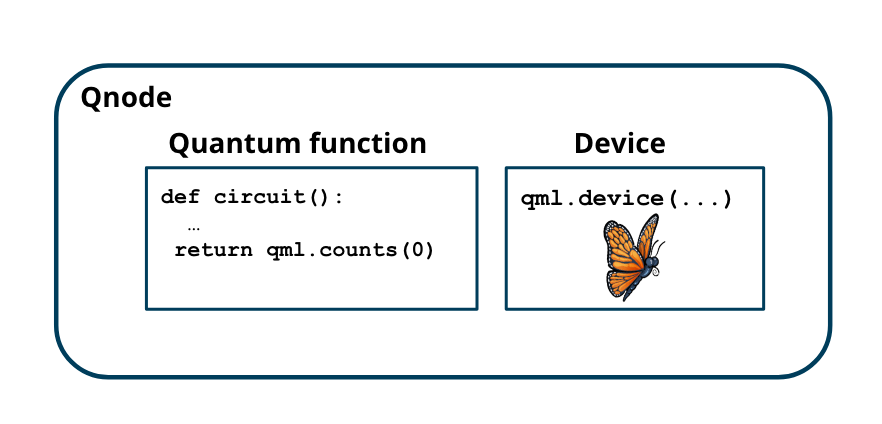

### Circuit
Dans PennyLane, un **circuit** est représenté par une **fonction quantique**. Une fonction quantique est une fonction Python qui doit contenir une ou plusieurs opérations quantiques (portes) et renvoyer une ou plusieurs mesures quantiques.

In [ ]:
def quantum_function():
    qml.Hadamard(wires=0)
    return qml.state()

In [ ]:
quantum_function()

### Device (machine)
Pour créer un circuit quantique, il faut spécifier la machine sur laquelle le circuit sera exécuté (‘[device](https://docs.pennylane.ai/en/stable/code/qml_devices.html)’). Tout objet de calcul qui peut appliquer des opérations quantiques et renvoyer une valeur de mesure est une machine quantique, que ce soit du **matériel quantique (MonarQ)** ou un **simulateur quantique** (`default.qubit`, `lightning.qubit`)

Dans PennyLane, `wires` fait référence au nombre de qubits. Par défaut, les qubits sont initialisés à l'état $\vert 0 \rangle$. Par exemple, si vous utilisez un device avec trois qubits (wires=3), votre état initial sera $\vert 000 \rangle$.

In [ ]:
#"default.qubit" est le simulateur quantique standard.
dev = qml.device('default.qubit', wires = 1) 

### Qnode
Pour exécuter un circuit quantique, il faut lier le circuit et le device à l’aide d’un [`QNode`](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNode.html). Un **QNode** encapsule la fonction qui décrit le circuit quantique et l’associe à une machine quantique (device) comme un simulateur. Il peut être défini facilement grâce au décorateur `@qml.qnode(dev)`.  

Par exemple, reprenons le circuit quantique du notebook 1 où nous appliquions une porte Hadamard à un qubit. Dans le notebook 1, nous avions manipulé le qubit en multipliant une matrice (H) au vecteur $\vert 0 \rangle$ avec `np.dot()`. Nous allons maintenant exécuter le circuit sur un device PennyLane via un QNode.

In [ ]:
@qml.qnode(dev) # qnode decorator
def quantum_function():
    qml.Hadamard(wires=0)
    return qml.state()

In [ ]:
quantum_function()

### Espace d'Hilbert (optionnel)

Dans un système de **$n$ qubits**, l’espace vectoriel associé, nommé espace de Hilbert, est de dimension $2^n$, ce qui signifie que l’état quantique est représenté par un vecteur de taille $2^n$.  

Par exemple, avec **deux qubits**, le vecteur d’état appartient à un espace de dimension $2^2 = 4$ et il contient **quatre amplitudes de probabilité**, correspondant aux quatre états de la base canonique :  

$$
\vert 00 \rangle, \vert 01 \rangle, \vert 10 \rangle, \vert 11 \rangle.
$$


In [ ]:
from print_latex import print_state_vector
state = quantum_function()
print_state_vector(state)

La fonction `draw_mpl` permet de visualiser le circuit créé par la fonction `quantum_function()`.

In [ ]:
result = qml.draw_mpl(quantum_function)()
print(result)

# 2.  Portes quantiques

Dans notebook 1, nous avons vu comment appliquer la **porte de Hadamard** à un qubit en utilisant la multiplication matricielle. Plus généralement, toute opération quantique correspond à une **matrice unitaire**, c’est-à-dire une matrice $U$ qui satisfait $U^\dagger U = I$. Cela garantit que l’évolution d’un état quantique conserve la normalisation.  

PennyLane facilite cette manipulation grâce à de nombreuses [portes quantiques](https://docs.pennylane.ai/en/stable/introduction/operations.html#qubit-operators). Certaines portes agissent sur un seul qubit (comme la porte de Hadamard ou les rotations), tandis que d'autres affectent plusieurs qubits (comme la porte CNOT). Concentrons-nous sur quelques portes importantes. 

1) **Porte X**
 
La porte $X$ inverse l'état d'un qubit, de manière analogue à la porte classique $NOT$. Si le qubit est dans l'état $\vert 0 \rangle$, il passe à l'état $\vert 1 \rangle$ et vice versa.

$$X \vert 0 \rangle = \vert 1 \rangle$$
$$X \vert 1 \rangle = \vert 0 \rangle$$

2) **Porte Hadamard**
 
La porte de Hadamard place un qubit dans une superposition égale. 
$$H\vert 0 \rangle = \frac{1}{\sqrt{2}}(\vert 0 \rangle + \vert 1 \rangle)$$
$$H\vert 1 \rangle = \frac{1}{\sqrt{2}}(\vert 0 \rangle - \vert 1 \rangle)$$

Essayons-le dans un circuit !

In [ ]:
dev = qml.device('default.qubit', wires = 1)
@qml.qnode(dev)
def circuit():
    qml.X(wires = 0 )
    qml.Hadamard(wires = 0)
    return qml.state()

Que retournera cette fonction ? Prenez une seconde pour y réfléchir, puis affichez l'état quantique en notation de Dirac.
(Attention ici la fonction qml.state() va retourner l'état complet et non la distribution de probabilité échantillonnée. Plus d'info suivra dans la section 3.)

In [5]:
from print_latex import print_state_vector #fonction pour visualiser l'état en format LaTeX
print_state_vector(circuit())

$$\left|\psi\right\rangle = (0.707107) \left|{00}\right\rangle + (0.707107) \left|{11}\right\rangle$$

Nous avons commencé avec un seul qubit, $\vert 0 \rangle$ et avons appliqué une porte $X$,
$$X \vert 0 \rangle = \vert 1 \rangle.$$
Nous avons ensuite appliqué une porte de Hadamard,
$$H \vert 1 \rangle = \frac{1}{\sqrt{2}}(\vert 0 \rangle - \vert 1 \rangle).$$

Nous avons créé une superposition!

3) **Porte CNOT**
   
La porte $CNOT$ effectue une opération $X$ sur un qubit cible uniquement si un qubit de contrôle est dans l'état $\vert 1 \rangle$. Si le qubit de contrôle est dans l'état $\vert 0 \rangle$, les deux qubits restent inchangés.
$$CNOT \vert 00 \rangle = \vert 00 \rangle$$
$$CNOT \vert 01 \rangle = \vert 01 \rangle$$
$$CNOT \vert 10 \rangle = \vert 11 \rangle$$
$$CNOT \vert 11 \rangle = \vert 10 \rangle$$

In [ ]:
dev = qml.device('default.qubit', wires = 2)
@qml.qnode(dev)
def circuit():
    qml.X(wires = 0) 
    qml.CNOT(wires = [0,1]) #0 est le qubit controle et 1 est le qubit cible
    return qml.state()

print_state_vector(circuit())

Nous travaillons avec deux qubits, nous commençons donc dans l'état $\vert 00 \rangle$ et appliquons ensuite une porte $X$ sur le premier qubit (index 0),
$$X\vert 00 \rangle = \vert 10 \rangle. $$
Nous avons ensuite appliqué la porte $CNOT$ avec le premier qubit comme contrôle et le deuxième qubit comme cible,
$$ CNOT \vert 10 \rangle = \vert 11 \rangle. $$
Cet exemple est trivial. Nous aurions pu nous contenter d'appliquer deux portes $X$. Cependant, nous verrons que les portes $CNOT$ sont très utiles pour intriquer des qubits.

### Aide-mémoire portes quantiques
Le tableau suivant résume les différentes portes quantiques, y compris leurs représentations de circuits, leurs formes matricielles et leurs actions sur les états de base de calcul. Vous pouvez l'utiliser comme référence.

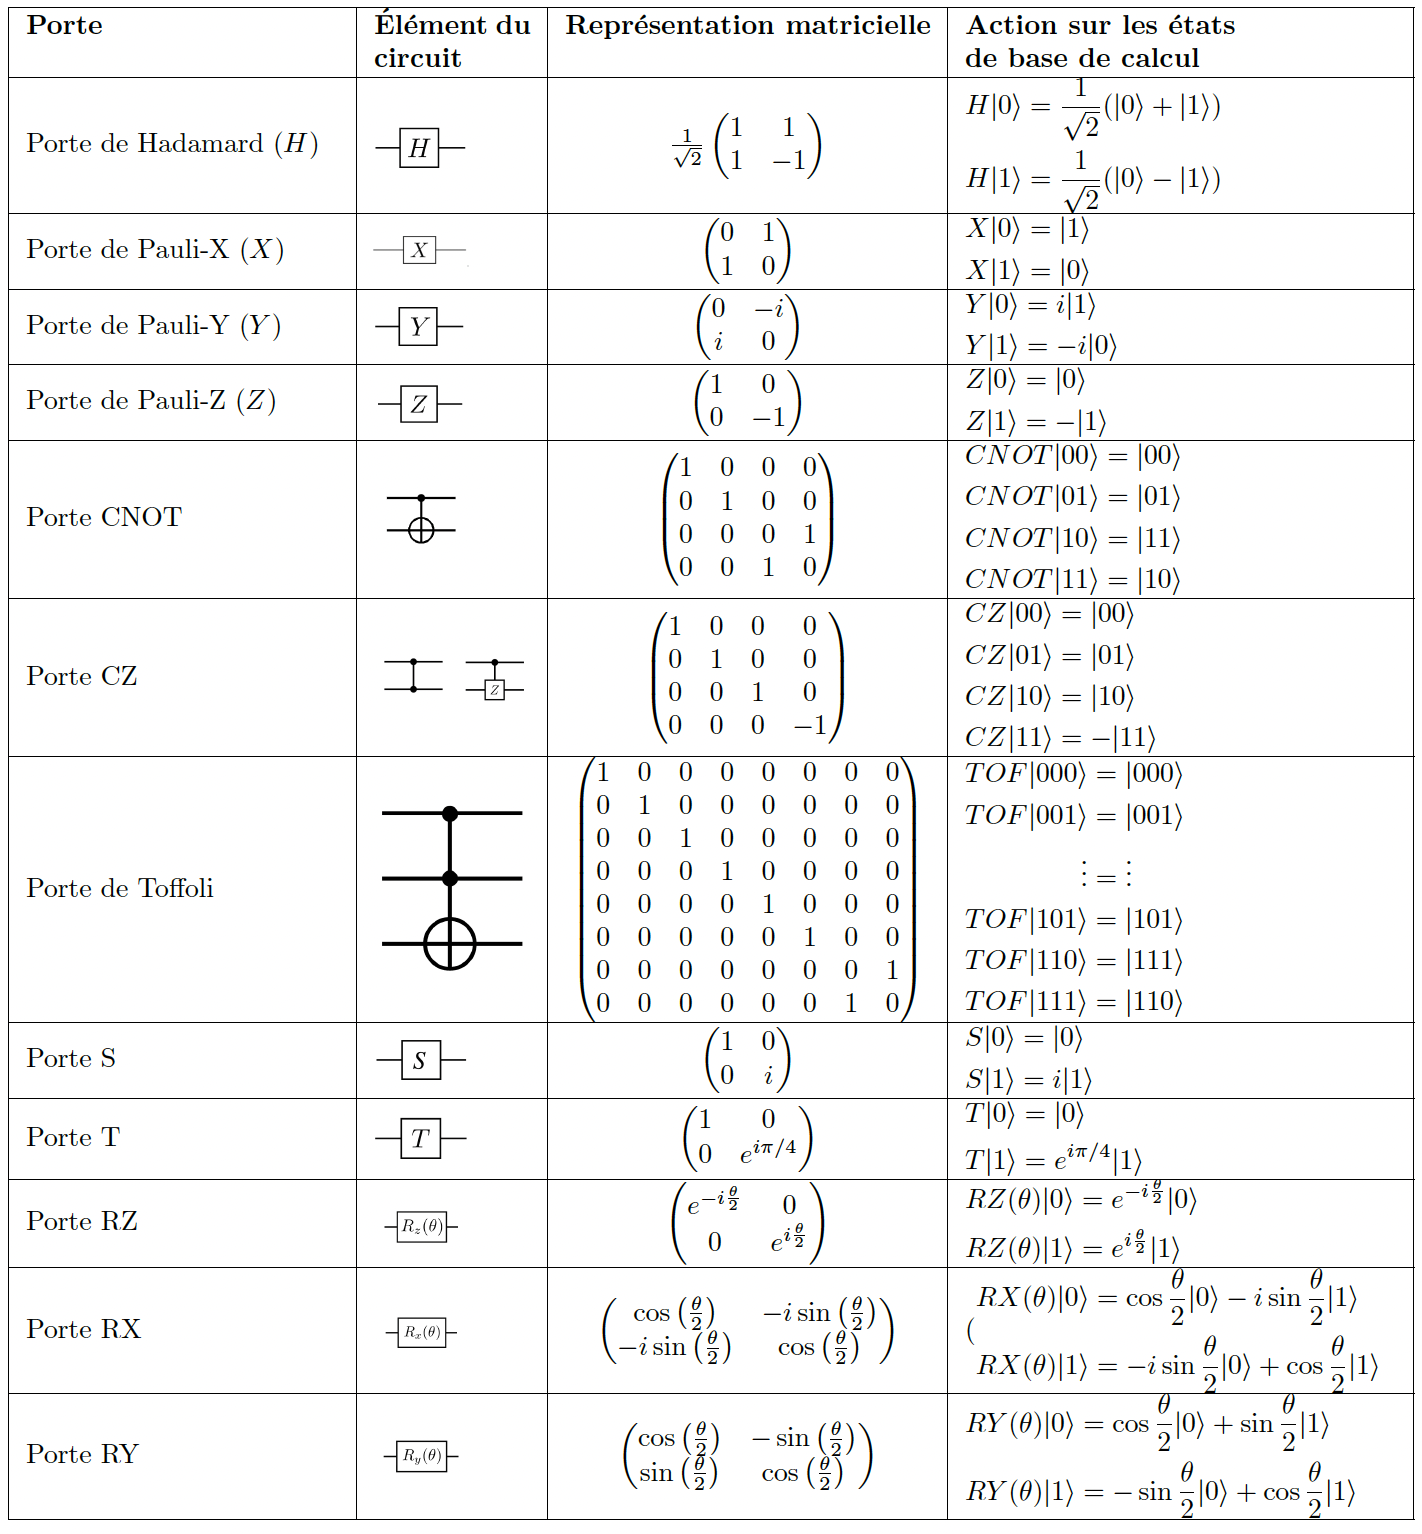

EXERCICE 1

---


Créez le circuit suivant en ajoutant des portes à la fonction `circuit()`.
N'oubliez pas de définir une machine (`device`) et de lier la machine et le circuit avec un `QNode`.

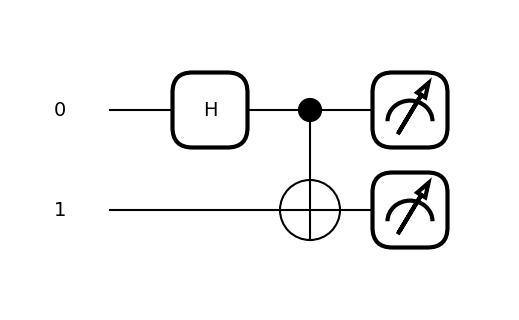

In [6]:
# Complétez cette ligne 
# Complétez cette ligne 
dev = qml.device("default.qubit", wires = 2)
@qml.qnode(dev)
def circuit():
    # Complétez cette ligne 
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    return qml.state()

Il s'agit d'un état de Bell, un état avec deux qubits maximalement intriqués. Vous verrez les autres états de Bell dans les prochains exercices.

In [7]:
correction_exercice1(circuit())
print_state_vector(circuit())

$$\left|\psi\right\rangle = (0.707107) \left|{00}\right\rangle + (0.707107) \left|{11}\right\rangle$$

# 3.  Preparation d'états

La première étape de nombreux algorithmes consiste à préparer un ou plusieurs qubits dans un état donné. Pour amener le qubit dans un état cible spécifique, nous devons déterminer la séquence d'opérations nécessaires pour le transformer à partir de son état initial. Cette séquence d'opérations doit être aussi petite que possible.


EXERCICE 2

---

Ajoutez des portes aux fonctions ci-dessous pour créer les trois états de Bell suivants. N'oubliez pas de définir un `device` et de lier le device et le circuit avec un `QNode`.

a)
$$\vert\phi_- \rangle = \frac{1}{\sqrt{2}}(\vert 00 \rangle - \vert 11 \rangle)$$

In [8]:
# Complétez cette ligne 
# Complétez cette ligne 
dev = qml.device("default.qubit", wires = 2)
@qml.qnode(dev)
def phi_moins():
    # Complétez cette ligne
    qml.X(wires = 0)
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    return qml.state()

#modify with function to view resulting state
#print_state_vector(phi_moins())
correction_exercice2_1(phi_moins())

b)
$$\vert\psi_+ \rangle = \frac{1}{\sqrt{2}}(\vert 01 \rangle + \vert 10 \rangle)$$
$$\vert\psi_- \rangle = \frac{1}{\sqrt{2}}(\vert 01\rangle - \vert 10 \rangle)$$

In [15]:
# Complétez cette ligne 
@qml.qnode(dev)
def psi_plus():
    # Complétez cette ligne 
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    qml.PauliX(wires = 0)

    return qml.state()
correction_exercice2_2(psi_plus())

# Complétez cette ligne 
@qml.qnode(dev)
def psi_moins():
    # Complétez cette ligne 
  qml.Hadamard(wires = 0)
  qml.CNOT(wires = [0,1])
  qml.Z(wires = 0)
  qml.X(wires = 1)
  return qml.state()
correction_exercice2_3(psi_moins())
#modify with function to view resulting state
#print_state_vector(psi_plus())

EXERCICE 3 (Optionnel) 

---

Créez l'état suivant. Appliquez d'abord la porte exacte pour créer l'état. Ensuite, utilisez la fonction [`qml.StatePrep()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.StatePrep.html) pour préparer l'état.

$$\frac{\sqrt{3}}{2}\vert 0\rangle-\frac{i}{2}\vert 1 \rangle$$

In [27]:
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def prepare_with_gate():
    # Complétez cette ligne 
    qml.RX(np.pi/3, wires = 0)
    return qml.state()


state = [np.sqrt(3)/2, -1j/2] # Complétez cette ligne 

@qml.qnode(dev)
def prepare_with_statePrep(state):
    # Complétez cette ligne 
    qml.StatePrep(state=state, wires=0)
    return qml.state()

print_state_vector(prepare_with_gate())
correction_exercice3(prepare_with_gate())
correction_exercice3(prepare_with_statePrep(state))
#print_state_vector(prepare_with_statePrep(state))

$$\left|\psi\right\rangle = (0.866025) \left|{0}\right\rangle + (-0.500000i) \left|{1}\right\rangle$$

# 4.  Mesure

Nous avons vu comment manipuler l’état des qubits à l’aide de portes quantiques. Cependant, lorsqu’on résout un problème avec un ordinateur quantique, il ne suffit pas de transformer l’état du système : il faut aussi **extraire des informations** après l’avoir manipulé. C’est là qu’interviennent les **mesures**, qui fournissent les résultats à la fin du circuit quantique.  

PennyLane propose plusieurs types de [mesures quantiques](https://docs.pennylane.ai/en/stable/introduction/measurements.html), mais attention ! Certaines fonctions sont spécifiques aux simulateurs et ne sont pas disponibles sur les ordinateurs quantiques réels, comme MonarQ.

Utilisons notre paire de Bell à deux qubits pour étudier différents types de mesures.
$$\vert\psi \rangle = \frac{1}{\sqrt{2}}(\vert 00 \rangle + \vert 11 \rangle)$$

In [2]:
def bell():
    qml.Hadamard(0)
    qml.CNOT([0,1])

# État (qml.state)

La mesure `qml.state()` fournit l'information la plus complète possible : elle renvoie directement l’état quantique $\vert \psi \rangle$ dans la base de calcul. 

Cependant, `qml.state()` **n’est disponible qu’en simulation**. Sur un ordinateur quantique réel comme MonarQ, il est impossible d’accéder directement à l’état quantique complet, car toute mesure provoque une décohérence du système.

In [ ]:
dev = qml.device('default.qubit',wires = 2)
@qml.qnode(dev)
def bell_statevector():
    bell()
    return qml.state()
    
print(bell_statevector())

Pour afficher le vecteur d'état en notation de Dirac, utilisez la fonction `print_state_vector()`.

In [ ]:
print_state_vector(bell_statevector())

# Probabilités (qml.probs)

La mesure d'un qubit est probabiliste. Rappelons que pour un état donné, 
$$\vert \psi \rangle  = \alpha \vert 0 \rangle + \beta \vert 1 \rangle,$$
la probabilité de mesurer $\vert 0 \rangle$ est $\vert \alpha\vert^2 = \alpha \alpha^* $ et la probabilité de mesurer $\vert \beta \vert^2 = \vert 1 \rangle$ est $\beta \beta^* $ où le * indique le conjugué complexe.

In [33]:
dev = qml.device('default.qubit', wires = 2)
@qml.qnode(dev)
def bell_probs():
    bell()
    return qml.probs()
    #return qml.probs(wires = 0) It can be useful to only specify one wire as needed

print(bell_probs())

[0.5 0.  0.  0.5]


EXERCICE 4 

---
Dans une expérience sur du matériel quantique réel, les résultats sont stochastiques et ne sont pas calculés exactement. Dans l'exercice ci-dessous, complétez la boucle `for` avec un nouveau `device` qui prend un nombre spécifié de tirs (`shots`). Assurez-vous de redéfinir votre `qnode` et votre fonction quantique. Vous pouvez ajouter un argument shot à votre `device` en utilisant le mot-clé `shots = `. Retournez les probabilités de mesurer 0 et 1 pour chaque nombre de `shots` dans la boucle. 



In [35]:
num_shots = [1,10,100,1000, 5000]
res = []
for shot in num_shots:
    dev = qml.device("default.qubit", wires = 2, shots = shot)# Complétez cette ligne 
    @qml.qnode(dev)# Complétez cette ligne 
    def bell_probs():
        bell()
        return qml.probs() # Complétez cette ligne 
    
    res.append(bell_probs())
print(res)

[array([1., 0., 0., 0.]), array([0.6, 0. , 0. , 0.4]), array([0.56, 0.  , 0.  , 0.44]), array([0.486, 0.   , 0.   , 0.514]), array([0.498, 0.   , 0.   , 0.502])]


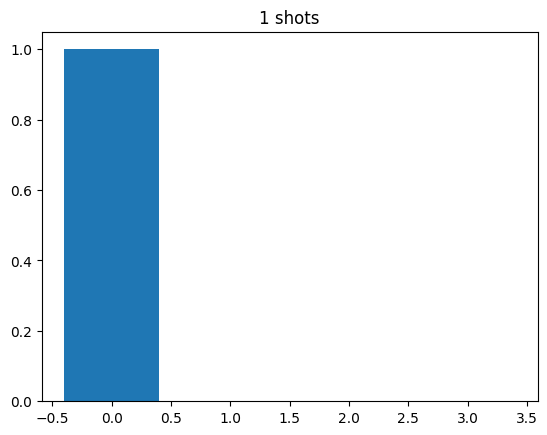

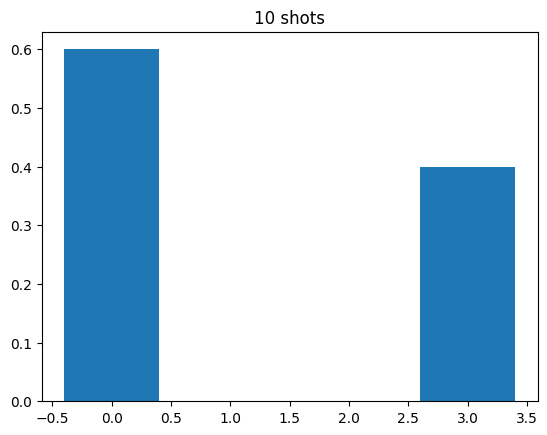

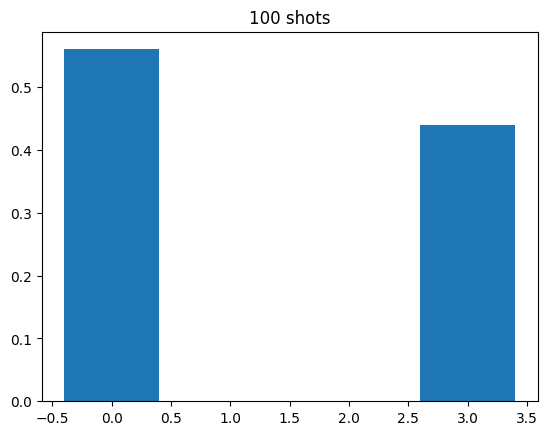

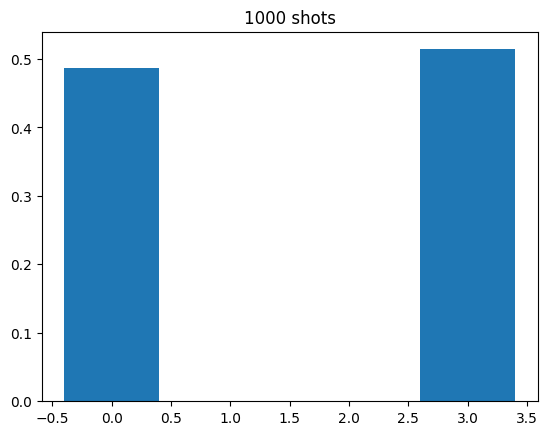

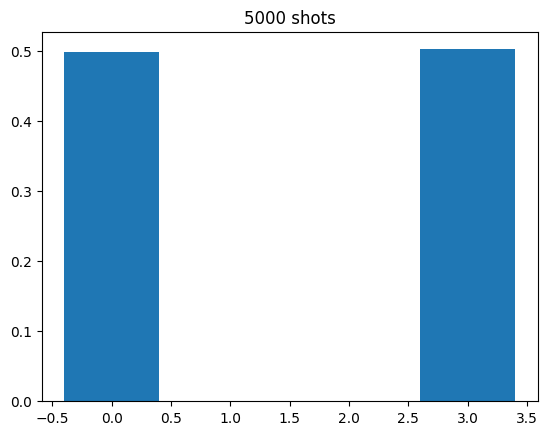

In [37]:
for i in range(len(res)):
    plt.bar([i for i in range(len(res[i]))], res[i])
    plt.title(f"{num_shots[i]} shots")
    plt.show()

Il y a une probabilité de 50 % de mesurer l'état $\vert 00 \rangle$ et 50 % de mesurer l'état $\vert 11 \rangle$. En revanche, les états $\vert 01 \rangle$ et $\vert 10 \rangle$ n'ont aucune chance d'être mesurés.

# Valeur moyenne (qml.expval)

Une valeur moyenne est une manière de mesurer le résultat « moyen » d'une mesure quantique si nous devions répéter l'expérience plusieurs fois. Au lieu de renvoyer un seul résultat de mesure (comme 0 ou 1), la valeur d'espérance nous indique la tendance d'un état quantique à s'aligner avec une direction de mesure particulière — dans l'exemple ci-dessous, le long de l'axe Z de la sphère de Bloch.

In [3]:
@qml.qnode(dev)
def bell_expvalZ():
    bell()
    return qml.expval(qml.PauliZ(wires = [0]))

print(bell_expvalZ())

NameError: name 'dev' is not defined

Si le résultat est +1, cela signifie que le qubit est entièrement dans l'état aligné avec l'axe Z de la sphère de Bloch (|0⟩).
Si le résultat est -1, le qubit est dans l'état opposé le long de l'axe Z de la sphère de Bloch (|1⟩).

EXERCICE 5 (optionnel)

---
Implémentez le circuit ci-dessous afin qu'il retourne la valeur moyenne de l'opérateur $Z$. Utilisez la fonction ['qml.expval()'](https://docs.pennylane.ai/en/stable/code/api/pennylane.expval.html). Quelle est cette valeur moyenne? L'aide-mémoire ci-haut peut vous aider à découvrir la porte Z.

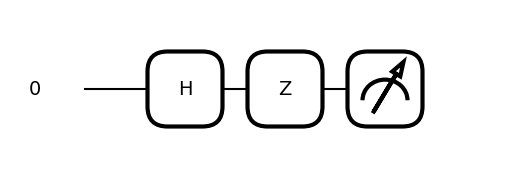

Calculons la valeur moyenne de l'opérateur  $ \langle Z \rangle $:


* $H|0\rangle = \frac{1}{\sqrt{2}} \left( |0 \rangle + |1 \rangle \right)$

* $Z \left( \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) \right) = \frac{1}{\sqrt{2}} \left( Z|0\rangle + Z|1\rangle \right) = \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right)$

* La valeur moyenne d'un opérateur $( O )$ dans un état $|\psi\rangle$ est donnée par: $\langle O \rangle = \langle \psi | O | \psi \rangle$


* $\langle Z \rangle = \left\langle \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right) \bigg| Z \bigg| \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right) \right\rangle$

* Que l'on développe:
$\langle Z \rangle = \frac{1}{2} \left( \langle 0 | Z | 0 \rangle - \langle 0 | Z | 1 \rangle - \langle 1 | Z | 0 \rangle + \langle 1 | Z | 1 \rangle \right)$

* Substituons les effets de $Z$: $\langle Z \rangle =\frac{1}{2} \left( \langle 0 | 0 \rangle + 0 - 0 - \langle 1 | 1 \rangle \right)$
* Puisque $ \langle 0 | 0 \rangle = 1$ et $\langle 1 | 1 \rangle = 1 $:

* Nous obtenons finalement $\langle Z \rangle = \frac{1}{2} (1 - 1) = 0$


In [6]:
dev = qml.device('default.qubit', wires = 1)
@qml.qnode(dev)
def circuit():
    # Complétez cette ligne 
    qml.Hadamard(wires = 0)
    qml.Z(wires = 0 )
    return qml.expval(qml.PauliZ(wires = 0))

correction_exercice5(circuit())

# Échantillon (qml.sample)

Ces mesures sont intéressantes, mais elles ont toutes été calculées exactement. En réalité, lors d'une expérience, nous obtenons un ensemble de mesures réelles échantillonnées à partir des probabilités de l'état des qubits $\vert \psi \rangle$. Dans ce cas, l'état $\vert \psi \rangle$ n'est pas accessible, mais nous pouvons « tricher » en mesurant notre circuit plusieurs fois.


Ainsi, si nous voulons imiter un ordinateur quantique, nous pouvons produire un ensemble de mesures à partir de l'état résultant. Pour ce faire, nous utilisons la fonction `qml.sample()`, pour laquelle nous devons spécifier le nombre d'échantillons ('shots') lors de la définition de la machine.

In [ ]:
dev = qml.device('default.qubit', wires = 2, shots = 10)
@qml.qnode(dev)
def bell_sample():
    bell()
    return qml.sample(wires = [0,1])

print(bell_sample())

# Comptes (qml.counts)

Les résultats de `qml.sample()` peuvent être difficiles à lire, il est donc utile de renvoyer les comptes de chaque état de base à la place.

In [ ]:
dev = qml.device('default.qubit', wires = 2, shots = 1000)
@qml.qnode(dev)
def bell_counts():
    bell()
    return qml.counts()

result = bell_counts()
print(result)

Sur du matériel quantique réel comme MonarQ, toutes les mesures sont stochastiques. Vous devez donc toujours spécifier le nombre de tirs ('shots'). Pour l'instant, la limite sur MonarQ est de 1000 tirs ('shots') par expérience. Les mesures disponibles sur MonarQ sont `qml.counts`, `qml.sample`, `qml.probs` et `qml.expval`.